In [1]:
# Import math functions (numpy) and sympy for creating formulars
from IPython.display import clear_output
import numpy as np
import sympy as sp
from fractions import Fraction
import matplotlib.pyplot as plt

In [2]:
# Import qiskit framework
from qiskit import IBMQ
from qiskit_optimization import QuadraticProgram
from qiskit import Aer
from qiskit.utils import QuantumInstance
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit.algorithms import QAOA

In [3]:
#IBMQ.load_account()
#provider = IBMQ.get_provider(hub='ibm-q')

In [4]:
clear_output()

## Define Functions

In [5]:
def construct_function(kl, kh, n, h):
    """Constructs the mathematical function to be optimized

    Args:
        kl (double): low k
        kh (double): high k
        n (int): number of heads
        h (list): values for each of the heads

    Returns:
        sympyfunction, dict: mathematical sympy function with coefficients
    """
    function = 0
    sp.init_printing(use_unicode=True)
    
    # construct variables for each permeability
    for i in range(1,n):
        globals()['q%s' % i] = sp.symbols('q'+str(i))
        globals()['h%s' % i] = sp.symbols('q'+str(i))
        
    # for each permeability, add its contribution to the total cost function
    for i in range(2,n):
        term = ((kl+globals()['q%s' % (i-1)]*(kh-kl))*(h[i-2]-h[i-1])+(kl+globals()['q%s' % (i)]*(kh-kl))*(h[i]-h[i-1]))**2
        function = function + term
        
    # expand and simplify the cost function
    function = sp.expand(function)
    
    # convert all square terms into linear terms as qi^2 = qi = 0 or 1 for all i and simplify the cost function
    for i in range(1,n):
        function = function.subs(sp.symbols('q'+str(i))**2, (sp.symbols('q'+str(i))))
        coeffs = sp.Poly(function).as_dict()
        
    # function in sympy form and coefficients of all terms in an easily readble dictionary form returned
    return function, coeffs

In [6]:
def generate_QP(coeffs, n, verbose=False):
    """Generates the Quadratic Program to be optimized

    Args:
        coeffs (dict): Contains the coefficients from the sympy funciton
        n (int): Number of heads

    Returns:
        QuadraticProgram: The quadratic program to optimize
    """
    qp = QuadraticProgram()
    for i in range(1,n):
        qp.binary_var('q'+str(i))
    constant = 0
    linear = {}
    quadratic = {}
    for key,value in coeffs.items():
        if sum(key) == 0:
            constant = float(value)
        elif sum(key) == 1:
            term = 'q'+str(np.argmax(key)+1)
            linear[term] = float(value)
        else:
            indices = [i[0] for i in np.argwhere(np.array(key)>0)]
            term = ('q'+str(indices[0]+1),'q'+str(indices[1]+1))
            quadratic[term] = float(value)
    qp.minimize(linear=linear, quadratic=quadratic, constant=constant)
    if verbose:
        print(qp.export_as_lp_string())
    return qp

In [7]:
def hydrologic_inverse_analysis(kl,kh,n,h, verbose=False):
    """Constructs and solves the mathematical function

    Args:
        kl (double): low k
        kh (double): high k
        n (int): number of heads
        h (list): values for each of the heads
        verbose (Bool): Output information or not

    Returns:
        list: list with the estimated k values for the heads
    """
    # Create the mathematical function
    function, coeffs = construct_function(kl,kh,n,h)
    if verbose:
        print('Function in Sympy:', function)
    # Generate the quadratic problem and solve it with Qiskit
    qp = generate_QP(coeffs,n,verbose)
    qins = QuantumInstance(backend=Aer.get_backend('qasm_simulator'), shots=1000, seed_simulator=123)
    meo = MinimumEigenOptimizer(min_eigen_solver=QAOA(reps=1, quantum_instance=qins))
    result = meo.solve(qp)
    if verbose:
        print('\nrun time:', result.min_eigen_solver_result.optimizer_time)
        print(result)
    k = [int(i) for i in list(kl+result.x*(kh-kl))]
    if verbose:
        print('k_res: ', k)
    return k

In [8]:
def evaluate_performance(k_true,k_res, verbose=False):
    """Evaluate the performance of the estimation by calculating missmatches and comparing them to the total number of values

    Args:
        k_true (list): True k values
        k_res (list): Estimated k values
        verbose (Bool): Output information or not

    Returns:
        double: Error rate
    """
    total_number = len(k_true)
    false_count = 0
    for i in range(len(k_true)):
        if k_true[i] != k_res[i]:
            false_count += 1
    error_rate = false_count / total_number
    if verbose:
        print('Error Rate = '+ str(error_rate*100)+'%')
    return error_rate

In [9]:
def construct_function_2D(kl, kh, n, h):
    """Constructs the mathematical function to be optimized

    Args:
        kl (double): low k
        kh (double): high k
        n (int): number of heads
        h (list): values for each of the heads

    Returns:
        sympyfunction, dict: mathematical sympy function with coefficients
    """
    function = 0
    sp.init_printing(use_unicode=True)
    
    # construct variables for each permeability
    for i in range(1,n):
        for j in range(1,n+1):
            globals()['qy%s%s' %(i,j)] = sp.symbols('qy'+str(i)+str(j))
    for i in range(1,n+1):
        for j in range(1,n):
            globals()['qx%s%s' %(i,j)] = sp.symbols('qx'+str(i)+str(j))
        
    # for each permeability, add its contribution to the total cost function
    for i in range(2,n+1):
        for j in range(2,n+1):
            term = ((kl+globals()['qx%s%s' %(i-1,j-1)] *(kh-kl))*(h[i-1][j]-h[i][j])+(kl+globals()['qx%s%s' %(i,j-1)] *(kh-kl))*(h[i+1][j]-h[i][j])+(kl+globals()['qy%s%s' %(i-1,j-1)] *(kh-kl))*(h[i][j-1]-h[i][j])+(kl+globals()['qy%s%s' %(i-1,j)] *(kh-kl))*(h[i][j+1]-h[i][j]))**2
            function = function + term
        
    # expand and simplify the cost function
    function = sp.expand(function)
    
    # convert all square terms into linear terms as qi^2 = qi = 0 or 1 for all i and simplify the cost function
    for i in range(1,n+1):
        for j in range(1,n+1):
            function = function.subs(sp.symbols('qx'+str(i)+str(j))**2, (sp.symbols('qx'+str(i)+str(j))))
            function = function.subs(sp.symbols('qy'+str(i)+str(j))**2, (sp.symbols('qy'+str(i)+str(j))))
    coeffs = sp.Poly(function).as_dict()
        
    # function in sympy form and coefficients of all terms in an easily readble dictionary form returned
    return function, coeffs

In [10]:
def coefficients_order_2D(n):
    order_list = []
    for i in range(1,n+1):
        for j in range(1,n):
            order_list.append('qx'+str(i)+str(j))
    for i in range(1,n):
        for j in range(1,n+1):
            order_list.append('qy'+str(i)+str(j))
    return order_list

In [11]:
def generate_QP_2D(coeffs, n, verbose=False):
    """Generates the Quadratic Program to be optimized

    Args:
        coeffs (dict): Contains the coefficients from the sympy funciton
        n (int): Number of heads

    Returns:
        QuadraticProgram: The quadratic program to optimize
    """
    qp = QuadraticProgram()
    for i in range(1,n):
        for j in range(1,n+1):
            qp.binary_var('qy'+str(i)+str(j))
    for i in range(1,n+1):
        for j in range(1,n):
            qp.binary_var('qx'+str(i)+str(j))
    constant = 0
    linear = {}
    quadratic = {}
    order_list = coefficients_order_2D(n)
    for key,value in coeffs.items():
        if sum(key) == 0:
            constant = float(value)
        elif sum(key) == 1:
            term = order_list[np.argmax(key)]
            linear[term] = float(value)
        else:
            indices = [i[0] for i in np.argwhere(np.array(key)>0)]
            term = (order_list[indices[0]],order_list[indices[1]])
            quadratic[term] = float(value)
    qp.minimize(linear=linear, quadratic=quadratic, constant=constant)
    if verbose:
        print(qp.export_as_lp_string())
    return qp

In [12]:
def hydrologic_inverse_analysis_2D(kl,kh,n,h, verbose=False):
    """Constructs and solves the mathematical function

    Args:
        kl (double): low k
        kh (double): high k
        n (int): number of heads
        h (list): values for each of the heads
        verbose (Bool): Output information or not

    Returns:
        list: list with the estimated k values for the heads
    """
    # Create the mathematical function
    function, coeffs = construct_function_2D(kl,kh,n,h)
    if verbose:
        print('Function in Sympy:', function)
    # Generate the quadratic problem and solve it with Qiskit
    qp = generate_QP_2D(coeffs,n,verbose)
    qins = QuantumInstance(backend=Aer.get_backend('qasm_simulator'), shots=1000, seed_simulator=123)
    meo = MinimumEigenOptimizer(min_eigen_solver=QAOA(reps=1, quantum_instance=qins))
    result = meo.solve(qp)
    if verbose:
        print('\nrun time:', result.min_eigen_solver_result.optimizer_time)
        print(result)
    k = [int(i) for i in list(kl+result.x*(kh-kl))]
    kx= np.array(k[:n*(n-1)]).reshape((n,n-1))
    ky = np.array(k[n*(n-1):]).reshape((n-1,n))
    if verbose:
        print('kx_res: ', kx)
        print('ky_res: ', ky)
    return kx, ky

## Small 1D Problem

Given: 3 heads with $h_1=1, h_2=\frac{1}{3}, h_3=0$ <br>
Assumption: $k_l = 1, k_h = 2$ <br>
Task: minimize  $f(q_1, q_2) = \frac{8}{9}q_1 − \frac{1}{9}q_2 − \frac{4}{9}q_1q_2 + \frac{1}{9}$

In [13]:
k_true = [1,2]

In [14]:
kl = 1
kh = 2
n = 3
h = [1,1/3,0]

In [15]:
k_res = hydrologic_inverse_analysis(kl,kh,n,h,verbose=True)

Function in Sympy: -0.444444444444444*q1*q2 + 0.888888888888889*q1 - 0.111111111111111*q2 + 0.111111111111111
\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: CPLEX

Minimize
 obj: 0.888888888889 q1 - 0.111111111111 q2 + [ - 0.888888888889 q1*q2 ]/2 +
      0.111111111111
Subject To

Bounds
 0 <= q1 <= 1
 0 <= q2 <= 1

Binaries
 q1 q2
End


run time: 0.05808305740356445
optimal function value: 2.7755575615628914e-17
optimal value: [0. 1.]
status: SUCCESS
k_res:  [1, 2]


In [16]:
error_rate = evaluate_performance(k_true, k_res, verbose=True)

Error Rate = 0.0%


## Larger 1D Problem

In [17]:
def generate_random_1D_data(kl, kh, n):
    """Generate random data for the value of the heads

    Args:
        kl (double): low k
        kh (double): high k
        n (int): number of heads

    Returns:
        list, list: Returns the random true k values and the linked head values
    """
    k_true = np.random.randint(2, size=n-1)*(kh-kl) +kl
    
    h1=np.random.rand()
    h2=np.random.rand()
    h=np.array([h1,h2])
    for i in range(1,n-1):
        h_next = h[i]+k_true[i-1]/k_true[i]*(h[i]-h[i-1])
        h=np.append(h, np.array([h_next]))
    return k_true, h

In [18]:
kl = 1
kh = 2
n = 15

In [19]:
# Generate a dataset with true ks and the head values
k_true, h = generate_random_1D_data(kl, kh, n)
print("k =", k_true)
print("h =", h)

k = [1 2 1 2 1 1 2 2 2 2 1 2 2 2]
h = [0.7353587  0.93766797 1.0388226  1.24113187 1.3422865  1.54459577
 1.74690504 1.84805967 1.9492143  2.05036894 2.15152357 2.35383284
 2.45498747 2.5561421  2.65729674]


In [20]:
# Estimate the k values, given only the head values
k_res = hydrologic_inverse_analysis(kl,kh,n,h,verbose=True)

Function in Sympy: -0.0409290394063433*q1*q2 + 0.0818580788126865*q1 - 0.0409290394063434*q10*q11 - 0.0204645197031717*q10*q9 - 0.0409290394063434*q11*q12 + 0.163716157625374*q11 - 0.0204645197031717*q12*q13 - 0.0204645197031717*q13*q14 + 0.0204645197031717*q13 + 0.0102322598515859*q14 - 0.0409290394063433*q2*q3 - 0.0204645197031716*q2 - 0.0409290394063433*q3*q4 + 0.163716157625373*q3 - 0.0409290394063432*q4*q5 - 0.0204645197031717*q4 - 0.0818580788126864*q5*q6 + 0.12278711821903*q5 - 0.0409290394063432*q6*q7 + 0.12278711821903*q6 - 0.0204645197031716*q7*q8 - 0.0204645197031717*q8*q9 + 0.0204645197031716*q8 + 0.0204645197031717*q9 + 0.0716258189611008
\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: CPLEX

Minimize
 obj: 0.081858078813 q1 - 0.020464519703 q2 + 0.163716157625 q3
      - 0.020464519703 q4 + 0.122787118219 q5 + 0.122787118219 q6
      + 0.020464519703 q8 + 0.020464519703 q9 + 0.163716157625 q11
      + 0.020464519703 q13 + 0.010232259852 q14 

In [21]:
# Compare the estimation
error_rate = evaluate_performance(k_true, k_res, verbose=True)

Error Rate = 14.285714285714285%


## 1D Problem Performance Analysis
Show how the number of heads influences the estimation error

Current run:  1
Current run:  2
Current run:  3
Current run:  4
Current run:  5
Current run:  6
Current run:  7
Current run:  8
Current run:  9
Current run:  10


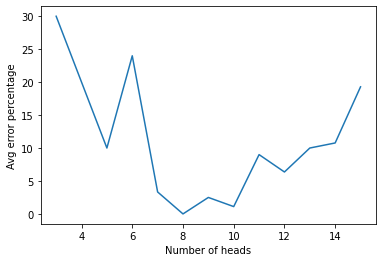

In [22]:
# Set everything up
runtime = 10
num_heads = 15
error_set = []
avg_set = []
# Start the runtime
for i in range(runtime):
    print("Current run: ", i+1)
    heads = []
    error_rates = []
    kl = 1
    kh = 2
    # Calculate the values for different amounts of heads
    for n in range(3,num_heads+1):
        k_true, h = generate_random_1D_data(kl, kh, n)
        k_res = hydrologic_inverse_analysis(kl, kh, n, h)
        error_rate = evaluate_performance(k_true, k_res)
        heads.append(len(h))
        error_rates.append(error_rate)
    error_set.append(error_rates)
# Do the statisics, take the average for each amount of heads
for i in range(num_heads-2):
    avg = 0
    for j in range(runtime):
        avg+=error_set[j][i]
    avg_set.append(avg/runtime*100)

plt.plot(heads, avg_set)
plt.xlabel("Number of heads")
plt.ylabel("Avg error percentage")
plt.show()

## 2D Problem

### Creating hydraulic head values

Creation of extended random binary-valued $k_{x,ext}$ and $k_{y,ext}$ arrays with 2 columns and rows more than we will extract from the inverse analysis.
For the $h_{ext}$ we choose the first two rows and the left and right column with random values to calculate a fitting (dim x dim) array for the $h$-values using formula (3) from the nature paper. 

In [23]:
dim=3
k_l=1 #low permeability
k_h=2 #high permeability

k_x_ext=np.random.randint(k_l, k_h+1, size=(dim+2, dim+1) )
k_y_ext=np.random.randint(k_l, k_h+1, size=(dim+1, dim+2) )
h_ext=np.random.rand(dim+2, dim+2) 

In [24]:
#above fields were used to obtain simulated hydraulic heads - equation 3 from the paper
for i in range(1,dim+1):
    for j in range(1, dim+1):
        h_ext[i+1][j]=-(1/k_x_ext[i][j-1])*(k_x_ext[i-1][j-1]*h_ext[i-1][j]-
                      k_y_ext[i-1][j-1]*h_ext[i][j-1]-
                      k_y_ext[i-1][j]*h_ext[i][j+1]+
                      (k_x_ext[i-1][j-1]+k_x_ext[i][j-1]+k_y_ext[i-1][j]+k_y_ext[i-1][j-1])*h_ext[i][j])

h = h_ext[1:dim+1,1:dim+1]
k_x= k_x_ext[1:dim+1,1:dim]
k_y= k_y_ext[1:dim+1,1:dim+1]

In [25]:
print("k_x_ext =", k_x_ext) #4 Zeilen, 3 Spalten
print("k_y_ext = ", k_y_ext)
print("h_ext =", h_ext)

k_x_ext = [[1 1 1 1]
 [2 2 2 2]
 [2 1 2 2]
 [2 2 2 2]
 [1 1 1 2]]
k_y_ext =  [[2 1 1 1 1]
 [2 1 1 2 1]
 [2 1 1 1 2]
 [1 1 2 1 2]]
h_ext = [[  0.06311814   0.7147349    0.06937761   0.2951601    0.11824296]
 [  0.32836544   0.57314392   0.11526522   0.57593042   0.44864479]
 [  0.30412962  -1.69080118   0.25168533  -1.30545111   0.65666151]
 [  0.68577661   5.77463247  -4.48520935   4.77565263   0.49368821]
 [  0.82320611 -20.07724053  16.36232325 -15.01726734   0.49867764]]


In [26]:
print("k_x =", k_x) #4 Zeilen, 3 Spalten
print("k_y = ", k_y)
print("h =", h)

k_x = [[2 2]
 [1 2]
 [2 2]]
k_y =  [[1 1 2]
 [1 1 1]
 [1 2 1]]
h = [[ 0.57314392  0.11526522  0.57593042]
 [-1.69080118  0.25168533 -1.30545111]
 [ 5.77463247 -4.48520935  4.77565263]]


In [27]:
kx_res, ky_res = hydrologic_inverse_analysis_2D(kl, kh, dim, h_ext, verbose=True)

Function in Sympy: 1.29241535753907*qx11*qx21 + 0.529988433330875*qx11*qy11 + 0.424849438398043*qx11*qy12 + 2.30308456619963*qx11 + 22.8817525270586*qx12*qx22 + 5.85913545963227*qx12*qy12 + 7.38296488010048*qx12*qy13 + 46.7426422768673*qx12 + 197.505132138045*qx21*qx31 + 18.4027079109788*qx21*qy11 + 14.7519825514786*qx21*qy12 + 97.1995800551938*qx21*qy21 + 87.7354554602555*qx21*qy22 + 551.516300233438*qx21 + 240.725599066888*qx22*qx32 + 18.9382163680456*qx22*qy12 + 23.8636207168011*qx22*qy13 + 112.632524669628*qx22*qy22 + 52.0781395995944*qx22*qy23 + 692.998788785782*qx22 + 427.78477341578*qx31*qy21 + 386.132243712201*qx31*qy22 + 2315.28099544855*qx31 + 366.598999672559*qx32*qy22 + 169.505157928572*qx32*qy23 + 1952.10879892092*qx32 + 6.04943300570938*qy11*qy12 + 36.301890769471*qy11 + 6.11055408328893*qy12*qy13 + 66.6822141475137*qy12 + 48.9067974340603*qy13 + 190.029957846173*qy21*qy22 + 1030.80737360292*qy21 + 79.3093628431031*qy22*qy23 + 1737.01993107596*qy22 + 355.8983181306*qy23 +